In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import tensorflow as tf

/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

In [4]:
mu = 1.0
sigma_x = 0.35
sigma_y = 0.2

nframes=25

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

xpos = np.zeros(nframes)+np.random.normal(0, 0.1, nframes)
ypos = np.zeros(nframes)+np.random.normal(0, 0.1, nframes)

In [5]:
Z = np.zeros((nframes, 60, 60))
for i in range(nframes):
    Z[i] = 12*(1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((X-xpos[i])**2/(2*sigma_x**2)
         + (Y-ypos[i])**2/(2*sigma_y**2))))

In [6]:
#Z = 200*multivariate_gaussian(pos, mu, Sigma) 
Zerr = 0.005*np.sqrt(Z)+0.002
Z += np.random.normal(0, 0.025, (nframes, 60,60))*np.sqrt(Z)


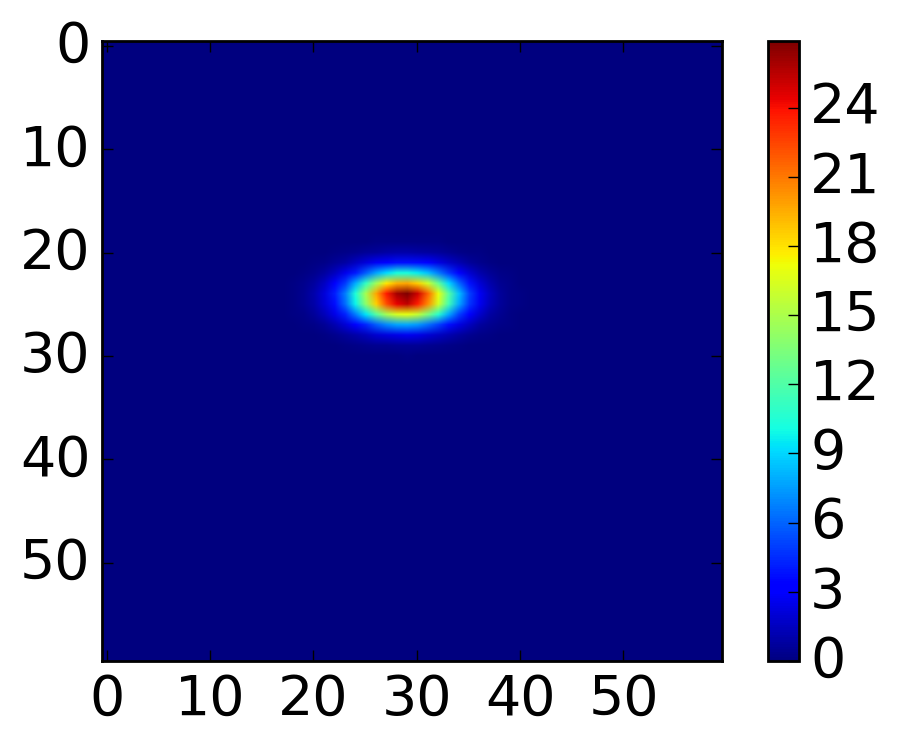

In [7]:
plt.imshow(Z[4])
plt.colorbar()

In [8]:
z_tensor = tf.placeholder(tf.float64, (nframes,N,N))
z_err = tf.placeholder(tf.float64, (nframes,N,N))

In [9]:
pos = tf.Variable(0.8*tf.ones((nframes, 2), dtype=tf.float64))
mu = tf.Variable(20*tf.ones(nframes, dtype=tf.float64))
sigma = tf.Variable(tf.ones((2), dtype=tf.float64))

In [10]:
#model = mu*(1/(2*np.pi*sigma[0]*sigma[1]) * tf.exp(-((X-pos[0])**2/(2*sigma[0]**2)
#     + (Y-pos[1])**2/(2*sigma[1]**2))))

In [11]:
#nll = 0.5*tf.reduce_sum((tf.divide((z_tensor - model), z_err)**2))

In [12]:
#gradient = tf.gradients(nll, [pos, mu, sigma])

#opt = tf.train.GradientDescentOptimizer(1e-6).minimize(nll, var_list=[pos, mu, sigma])

#hess = tf.hessians(nll, [pos, mu, sigma])

#init = tf.global_variables_initializer()

In [13]:
Zmod = 12*(1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((X+0.1)**2/(2*sigma_x**2)
     + (Y-0.9)**2/(2*sigma_y**2))))[25:55, 15:45]

In [14]:
#plt.imshow(Zmod, interpolation='nearest')

In [15]:
def p_operator(image, xshift, yshift, pad):
        print(tf.shape(image))
        ss = 1

        pss = int(pad*ss)
        lx, ly = Zmod.shape[0], Zmod.shape[1]
        xshift_model = xshift*ss
        yshift_model = yshift*ss
        whole_x = tf.cast(xshift, tf.int32)
        frac_x = np.mod(xshift_model, 1)
        whole_y = tf.cast(yshift, tf.int32)
        frac_y = np.mod(yshift_model, 1)


        ur = frac_x*frac_y
        ul = (1-frac_x)*(frac_y)
        lr = frac_x*(1-frac_y)
        ll = (1-frac_x)*(1-frac_y)




        output = np.zeros_like(Z[0])
        '''
        if pss+whole_x < 0:
            return output
        if pss + whole_x + lx >= len(output[:,0]):
            return output
        if pss + whole_y < 0:
            return output
        if pss + whole_y + ly >= len(output[0]):
            return output
        '''
        print(pss, N, lx, whole_x)
        paddings = [[pss +whole_x, N-pss-lx-whole_x], [pss +whole_y, N-pss-whole_y-ly]]
        output = tf.pad(ll*image, paddings, 'constant')
        paddings = [[pss +whole_x+1, N-pss-lx-whole_x-1], [pss +whole_y, N-pss-whole_y-ly]]
        output += tf.pad(lr*image, paddings, 'constant')
        paddings = [[pss +whole_x, N-pss-lx-whole_x], [pss +whole_y+1, N-pss-whole_y-ly-1]]
        output += tf.pad(ul*image, paddings, 'constant')
        paddings = [[pss +whole_x+1, N-pss-lx-whole_x-1], [pss +whole_y+1, N-pss-whole_y-ly-1]]
        output += tf.pad(ur*image, paddings, 'constant')
        #output[pss + whole_x:pss + whole_x + lx, pss + whole_y:pss + whole_y + ly] += ll*image
        #output[pss + whole_x+1:pss + whole_x+1 + lx, pss + whole_y:pss + whole_y + ly] += lr*image
        #output[pss + whole_x:pss + whole_x + lx, pss + whole_y+1:pss + whole_y+1 + ly] += ul*image
        #output[pss + whole_x+1:pss + whole_x+1 + lx, pss + whole_y+1:pss + whole_y+1 + ly] += ur*image

        return output

In [16]:
amp = tf.Variable(0.8*tf.ones(nframes, dtype=tf.float64))
z_mod = tf.Variable(Zmod*tf.ones((Zmod.shape[0],Zmod.shape[1]), dtype=tf.float64))

print(np.shape(Zmod))
print(z_mod)

(30, 30)
<tf.Variable 'Variable_4:0' shape=(30, 30) dtype=float64_ref>


In [17]:
pos = tf.Variable(13*tf.ones((nframes,2), dtype=tf.float64))
#transforms = [1, 0, -3, 0, 1, -4, 0, 0]
#Ztwo = tf.contrib.image.translate(z_mod, transforms, interpolation='bilinear')


z_test = [amp[i]*p_operator(z_mod, pos[i,0], pos[i,1], 2) for i in range(nframes)]

Tensor("Shape:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast:0", shape=(), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_2:0", shape=(), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_4:0", shape=(), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_6:0", shape=(), dtype=int32)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_8:0", shape=(), dtype=int32)
Tensor("Shape_5:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_10:0", shape=(), dtype=int32)
Tensor("Shape_6:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_12:0", shape=(), dtype=int32)
Tensor("Shape_7:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_14:0", shape=(), dtype=int32)
Tensor("Shape_8:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_16:0", shape=(), dtype=int32)
Tensor("Shape_9:0", shape=(2,), dtype=int32)
2 60 30 Tensor("Cast_18:0", shape=(), dtype=int32)
Tensor("Shape_10:0", shape=(2,), dtype=int32)
2 6

In [18]:
nll = 0.5*tf.reduce_sum((tf.divide((z_tensor - z_test), z_err)**2))
gradient = tf.gradients(nll, [pos, amp, z_mod])
opt = tf.train.GradientDescentOptimizer(1e-6).minimize(nll, var_list=[pos, amp, z_mod])
hess = tf.hessians(nll, [pos, amp, z_mod])
init = tf.global_variables_initializer()

In [19]:
def p_operator_orig(image, xshift, yshift, pad):
        if np.abs(xshift) < 1e-8:
            if np.abs(yshift) < 1e-8:
                return image
        pss = int(pad)
        lx, ly = image.shape[0], image.shape[1]
        xshift_model = xshift
        yshift_model = yshift
        whole_x = int(np.floor(xshift_model))
        frac_x = np.mod(xshift_model, 1)
        whole_y = int(np.floor(yshift_model))
        frac_y = np.mod(yshift_model, 1)


        ur = frac_x*frac_y
        ul = (1-frac_x)*(frac_y)
        lr = frac_x*(1-frac_y)
        ll = (1-frac_x)*(1-frac_y)




        output = np.zeros_like(Z[0])

        if pss+whole_x < 0:
            return output
        if pss + whole_x + lx >= len(output[:,0]):
            return output
        if pss + whole_y < 0:
            return output
        if pss + whole_y + ly >= len(output[0]):
            return output

        output[pss + whole_x:pss + whole_x + lx, pss + whole_y:pss + whole_y + ly] += ll*image
        output[pss + whole_x+1:pss + whole_x+1 + lx, pss + whole_y:pss + whole_y + ly] += lr*image
        output[pss + whole_x:pss + whole_x + lx, pss + whole_y+1:pss + whole_y+1 + ly] += ul*image
        output[pss + whole_x+1:pss + whole_x+1 + lx, pss + whole_y+1:pss + whole_y+1 + ly] += ur*image

        return output

In [23]:
optim = tf.contrib.opt.ScipyOptimizerInterface(loss=nll,
                                                   method='L-BFGS-B', options={'maxiter': 2000})

nll_history = []

data = {z_tensor: Z, z_err: Zerr}

with tf.Session() as sess:
    # initialize
    sess.run(fetches=tf.global_variables_initializer())

    for i in range(10):
        # gradient step
        optim.minimize(session=sess, feed_dict=data)
        # sess.run(fetches=train_op, feed_dict={x: x_obs})

        # update loss
        nll_history.append(sess.run(fetches=nll, feed_dict=data))

    params = sess.run([pos, amp, z_mod])
    #pred = sess.run(model, feed_dict=data)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123440.177889
  Number of iterations: 469
  Number of functions evaluations: 511
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123440.177100
  Number of iterations: 2
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123440.175941
  Number of iterations: 4
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123440.175824
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123440.1

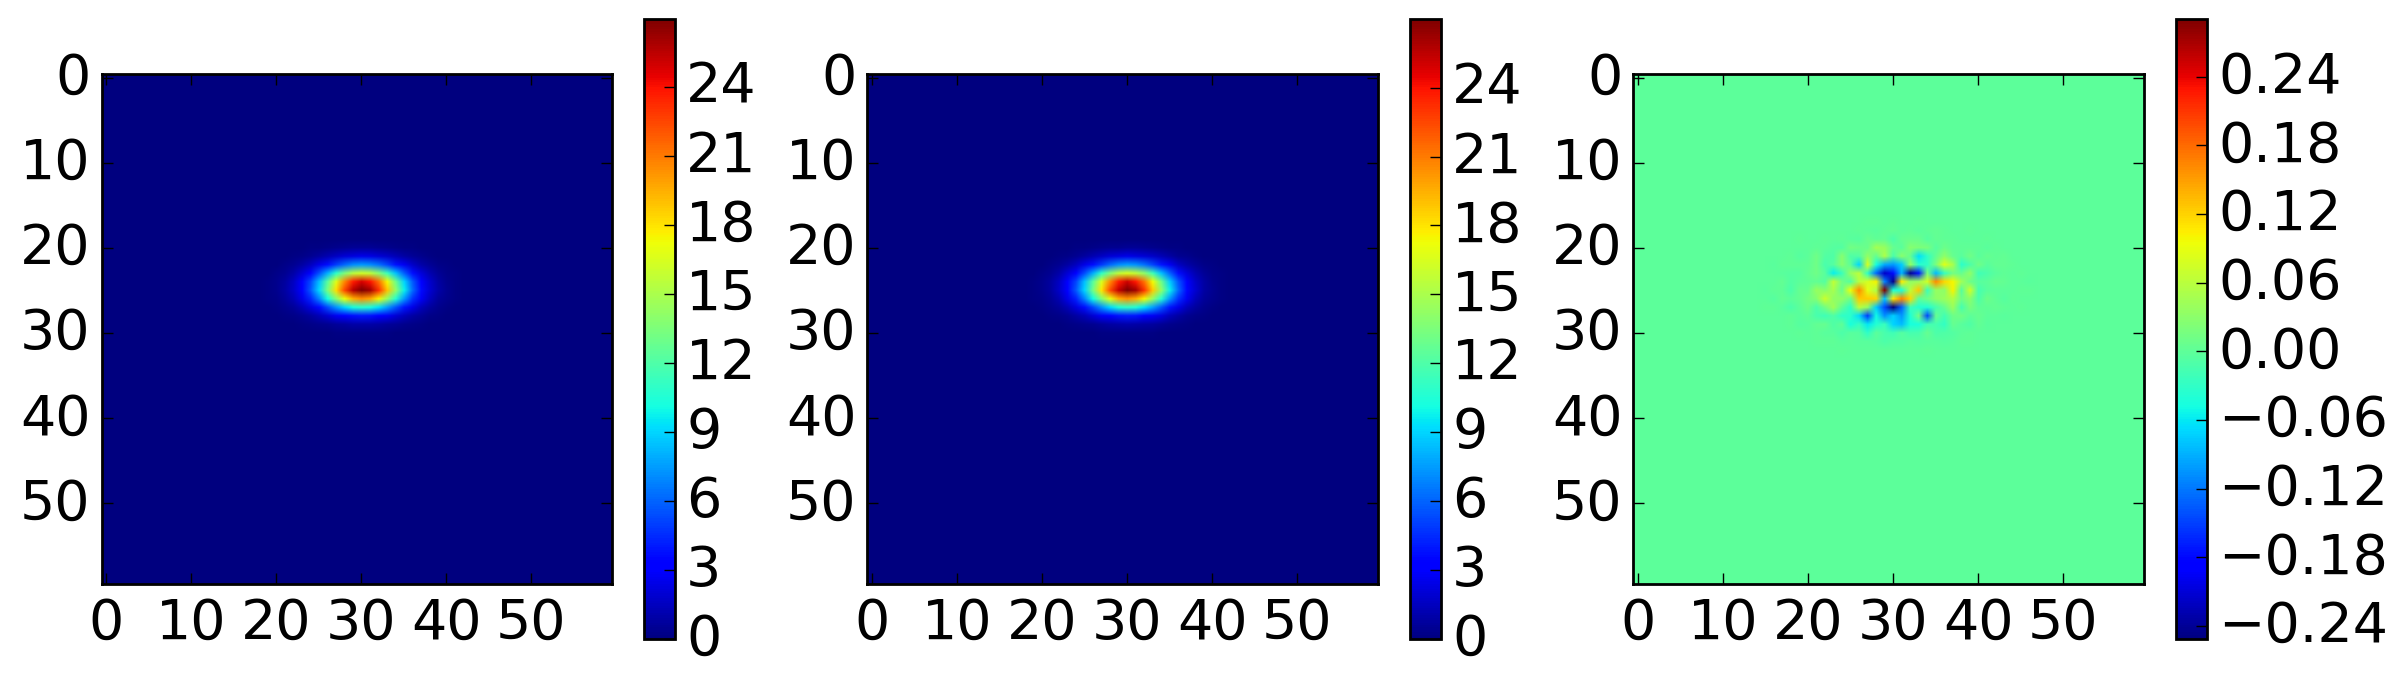

In [30]:
j = 24
model = params[1][j]*p_operator_orig(params[2], params[0][j][0], params[0][j][1], 2)
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.imshow(model)
plt.colorbar()
plt.subplot(132)
plt.imshow(Z[j])
plt.colorbar()
plt.subplot(133)
plt.imshow(model-Z[j])
plt.colorbar()
plt.show()

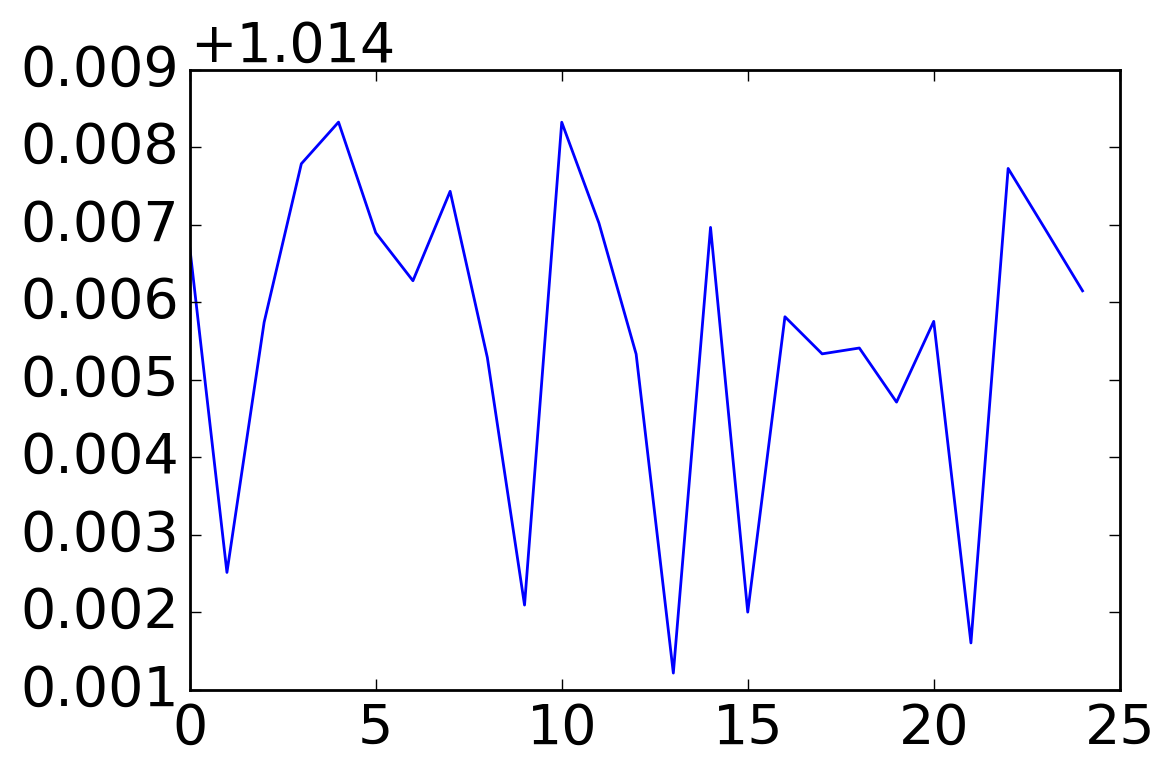

In [26]:
plt.plot(params[1])

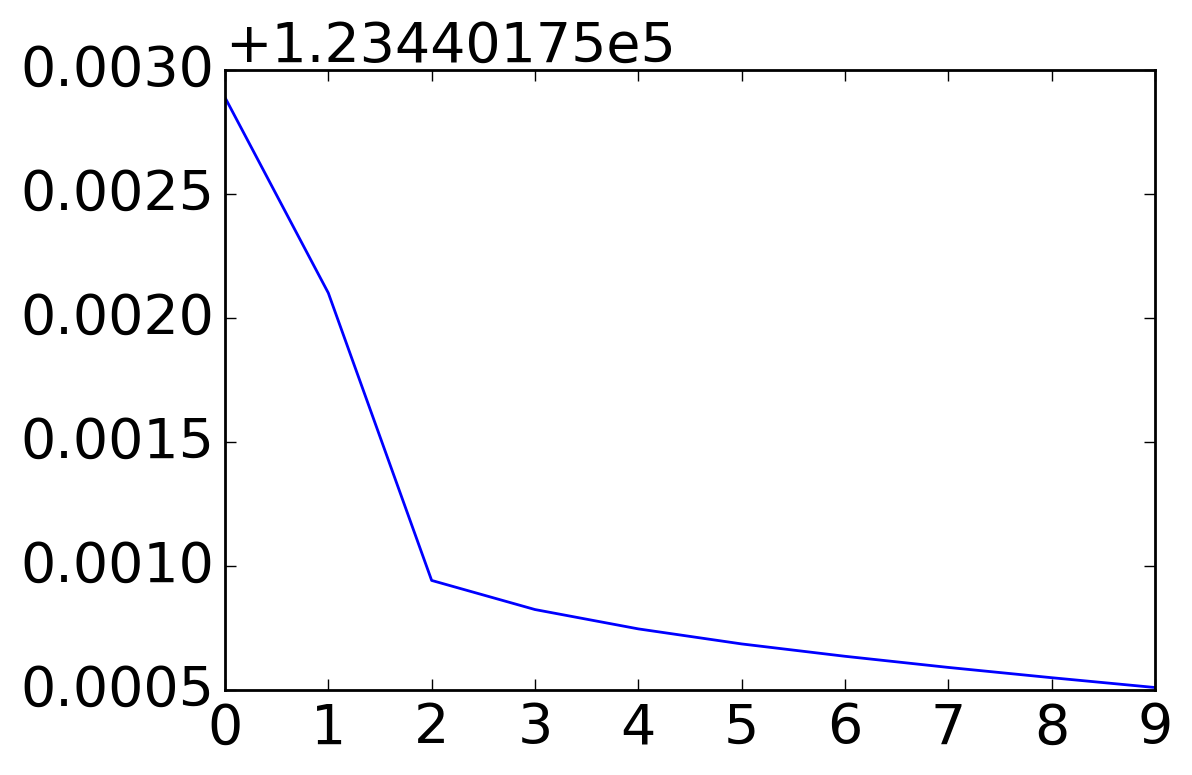

In [27]:
plt.plot(nll_history)

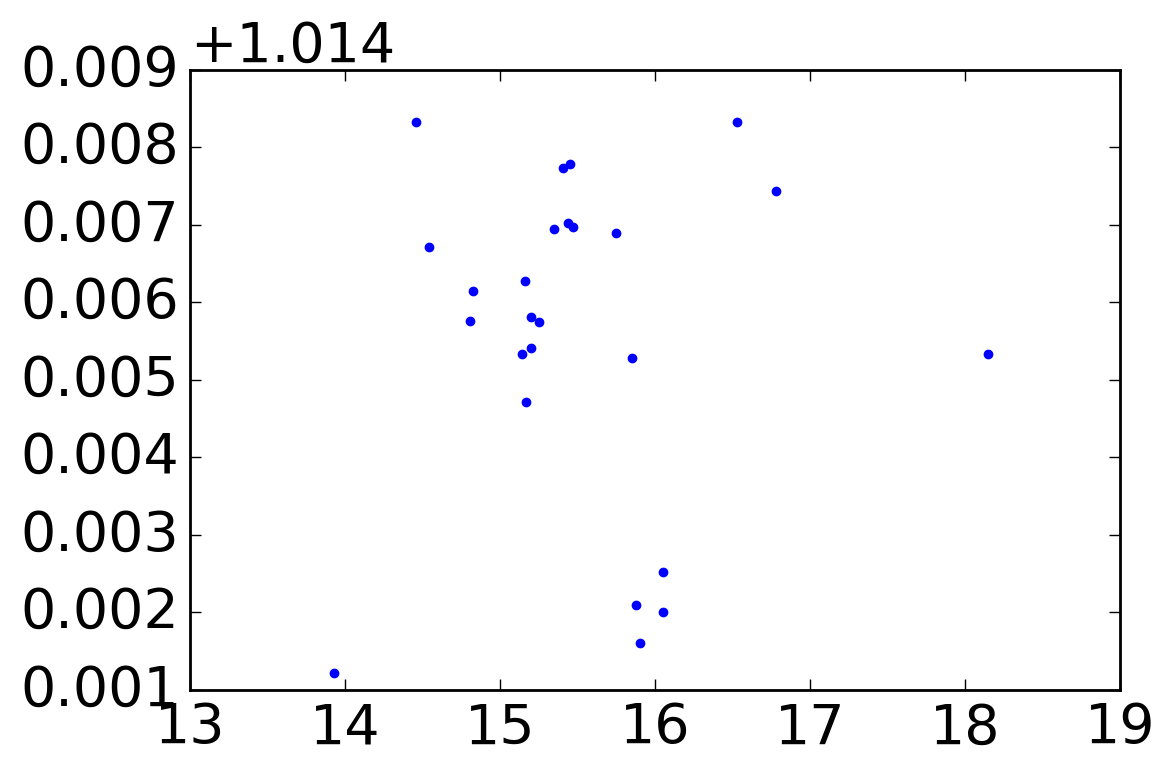

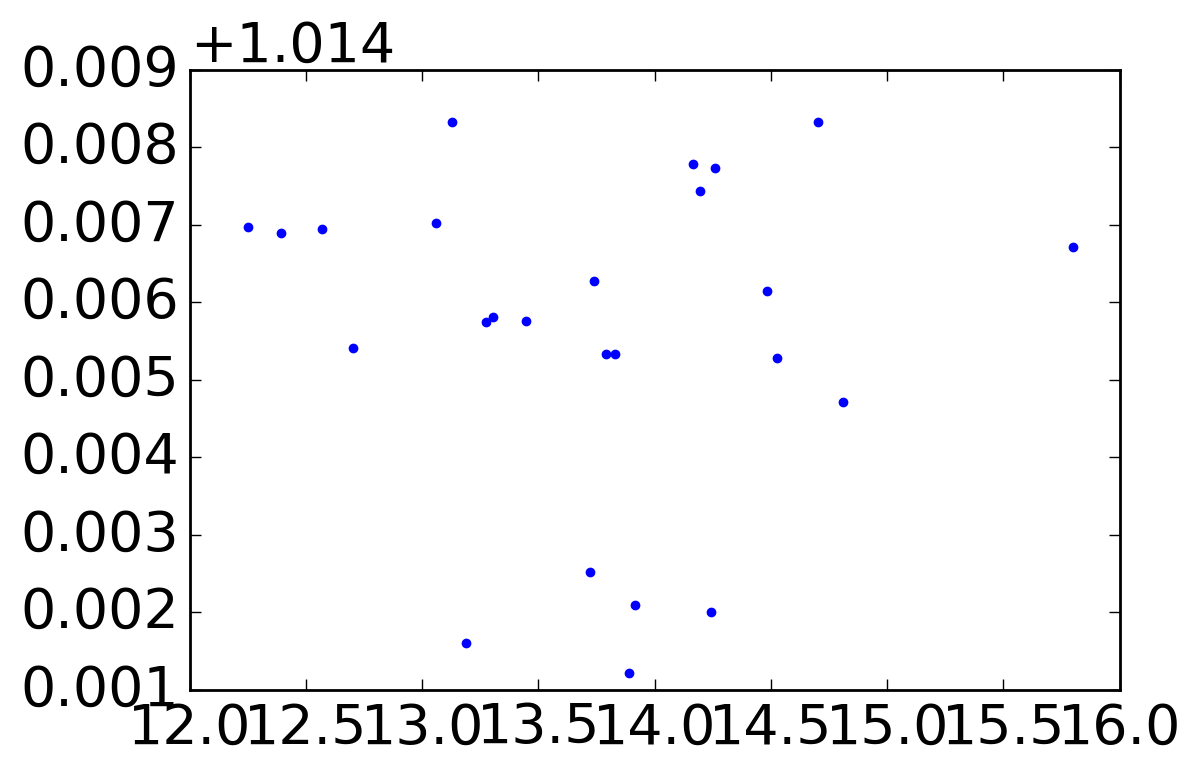

In [28]:
plt.plot(params[0][:,0], params[1], '.')
plt.show()
plt.plot(params[0][:,1], params[1], '.')
plt.show()